In [103]:
#%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from azureml.core import Experiment

In [104]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

ws = Workspace(subscription_id, resource_group, workspace_name)



In [105]:
experiment = Experiment(workspace = ws, name = "lr-experiment")

In [106]:
run = experiment.start_logging(snapshot_directory=None)

In [107]:
df = Dataset.get_by_name(ws, name='Time_Deposits_Data_Set')
#df.to_pandas_dataframe()

In [108]:
df = df.to_pandas_dataframe()

In [109]:
df.head()
df.dtypes

Customer_ID                                  int64
Gender                                      object
Birth_Date                          datetime64[ns]
Ref_Date                            datetime64[ns]
Marital_Status                              object
Children_Num                                 int64
Occupation_Category                         object
Total_Income                                 int64
Payroll_Flag                                 int64
Business_Flag                                int64
Saving_Current_Accounts_Flag               float64
Investment_Products_Flag                   float64
Insurance_Products_Flag                    float64
Business_Loans_Flag                        float64
Housing_Loans_Flag                         float64
Consumer_Loans_Flag                        float64
Credit_Cards_Flag                          float64
Saving_Current_Balance                     float64
Investment_Products_Balance                float64
Insurance_Balances             

In [110]:
def full_log_likelihood(w, X, y):
    score = np.dot(X, w).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def null_log_likelihood(w, X, y):
    z = np.array([w if i == 0 else 0.0 for i, w in enumerate(w.reshape(1, X.shape[1])[0])]).reshape(X.shape[1], 1)
    score = np.dot(X, z).reshape(1, X.shape[0])
    return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

def mcfadden_rsquare(w, X, y):
    return 1.0 - (full_log_likelihood(w, X, y) / null_log_likelihood(w, X, y))

def mcfadden_adjusted_rsquare(w, X, y):
    k = float(X.shape[1])
    return 1.0 - ((full_log_likelihood(w, X, y) - k) / null_log_likelihood(w, X, y))
def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)
def true_probabilities (p,a):
    tp =p/(p+(1-p)/a)
    return tp

In [111]:
recode = {True:"1",False:"0"}

df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].map(recode)
df['Time_Deposits_Flag'].astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
119995    0
119996    1
119997    0
119998    0
119999    0
Name: Time_Deposits_Flag, Length: 120000, dtype: int64

In [112]:
df['Time_Deposits_Flag'].value_counts()

0    118663
1      1337
Name: Time_Deposits_Flag, dtype: int64

In [113]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='object' and col not in ['Birth_Date','Ref_Date']:
            
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])

In [114]:
for col in df.columns[1:-1]:       
       if df[col].dtype =='float' and ('_Num' in col or '_Flag' in col):
            
            df[col] = df[col].astype('int')

In [115]:
df['Total_Income'] = df['Total_Income'].astype('float')

In [116]:
df['Time_Deposits_Flag'] = df['Time_Deposits_Flag'].astype('int')

In [117]:
df = df.drop(['Birth_Date','Ref_Date'],axis = 1)

In [118]:
X = df[df.columns[1:]].drop(['Time_Deposits_Flag'],axis = 1)

In [119]:
y = df['Time_Deposits_Flag']

In [120]:
f_count = df[df['Time_Deposits_Flag']== 0].iloc[:,0].count()
t_count = df[df['Time_Deposits_Flag']== 1].iloc[:,0].count()
weights = {1:1,0:t_count*3/f_count}

In [121]:
run.log_table('Weights',weights)

In [122]:
LR = LogisticRegression(class_weight = weights,solver = 'liblinear',max_iter = 1000)#class_weight = 'balanced'

In [123]:
selector = RFE(LR)

In [124]:
selector.fit(X,y)

RFE(estimator=LogisticRegression(C=1.0,
                                 class_weight={0: 0.033801606229405964, 1: 1},
                                 dual=False, fit_intercept=True,
                                 intercept_scaling=1, l1_ratio=None,
                                 max_iter=1000, multi_class='auto', n_jobs=None,
                                 penalty='l2', random_state=None,
                                 solver='liblinear', tol=0.0001, verbose=0,
                                 warm_start=False),
    n_features_to_select=None, step=1, verbose=0)

In [125]:
print(classification_report(y,  selector.predict(X)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    118663
           1       0.04      0.14      0.07      1337

    accuracy                           0.96    120000
   macro avg       0.52      0.55      0.52    120000
weighted avg       0.98      0.96      0.97    120000



In [126]:
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(selector.score(X, y)))

Accuracy of logistic regression classifier on train set: 0.9551


In [127]:
y_pred = selector.predict(X)

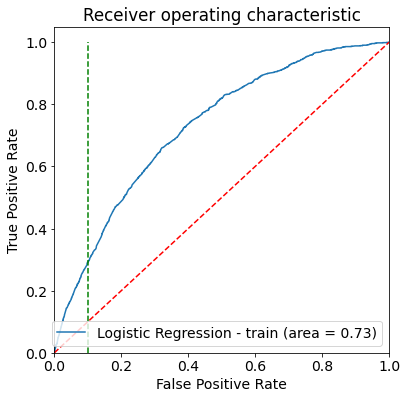

In [128]:
logit_roc_auc = roc_auc_score(y, selector.predict(X))
fpr, tpr, thresholds = roc_curve(y, selector.predict_proba(X)[:,1])
auc_train = roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Logistic Regression - train (area = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1],'r--')
plt.plot([0.1,0.1],[0,1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [129]:
run.log_image(name='roc curve', plot=fig)

In [130]:
run.log('auc (train)', auc_train)

In [131]:
df_lift = pd.DataFrame(zip(y,selector.predict_proba(X)[:,1]),columns =['Actual','Predicted']).sort_values(by ='Predicted',ascending = False)

In [132]:
'lift at 10% is {:.03f}'.format(df_lift['Actual'].head(12000).sum()/df_lift['Actual'].sum()/0.1)

'lift at 10% is 2.857'

In [133]:
pd.DataFrame(zip(X.columns[selector.support_],selector.ranking_),columns=['Column','Importance']).sort_values(by ='Importance')

,Column,Importance
25,Occupation_Category__default,1
2,Saving_Current_Accounts_Flag,1
3,Investment_Products_Flag,1
4,Business_Loans_Flag,1
5,Housing_Loans_Flag,1
7,Credit_Cards_Flag,1
8,Branch_Trans_Num,1
9,APS_Trans_Num,1
10,Phone_Trans_Num,1
21,Occupation_Category__Employees,1


In [134]:
run.complete()

In [135]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [136]:
import json

# Get logged metrics
print("Metrics:")
metrics = run.get_metrics()
for metric_name in metrics:
    print(metric_name, ":", metrics[metric_name])

# Get output files
print("\nFiles:")
files = run.get_file_names()
for file in files:
    print(file)

Metrics:
Weights : {'1': 1, '0': 0.033801606229405964}
roc curve : aml://artifactId/ExperimentRun/dcid.05a46113-374b-46fa-9ba7-4c59ce5a7799/roc curve_1617098106.png
auc (train) : 0.7258801442506733

Files:
roc curve_1617098106.png


In [137]:
import os

download_folder = 'downloaded-files'

# Download files in the "outputs" folder
run.download_files(prefix='outputs', output_directory=download_folder)

# Verify the files have been downloaded
for root, directories, filenames in os.walk(download_folder): 
    for filename in filenames:  
        print (os.path.join(root,filename))

In [138]:
run.get_details_with_logs()

{'runId': '05a46113-374b-46fa-9ba7-4c59ce5a7799',
 'target': 'local',
 'status': 'Completed',
 'startTimeUtc': '2021-03-30T09:53:01.603195Z',
 'endTimeUtc': '2021-03-30T09:55:12.34543Z',
 'properties': {},
 'inputDatasets': [],
 'outputDatasets': [],
 'logFiles': {},
 'submittedBy': 'Evaggelos Kontogeorgakos'}